In [1]:
from IPython.display import display

from ipywidgets import IntProgress
from ipywidgets import SelectMultiple, interact

# Objective:

Designing a 6 hours ahead water inflow forecast.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from typing import Union

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

from darts import TimeSeries
from darts.utils.missing_values import extract_subseries
from darts.models.forecasting.regression_model import RegressionModel
from darts.models.forecasting.xgboost import XGBModel

In [3]:
target = "FB20F11_81"


def plot_lagged_variables_comparison(data, var1, var2, lags):
    if var2 is None:
        var2 = var1

    list_of_dfs = []
    for lag in lags:
        list_of_dfs.append(
            pd.DataFrame(
                {
                    var1: data[var1].values,
                    f"lagged_{var2}": data[var2].shift(lag).values,
                    "lag_order": f"L{lag}",
                }
            )
        )

    sns.lmplot(
        pd.concat(list_of_dfs),
        x=f"lagged_{var2}",
        y=var1,
        hue="lag_order",
        markers=".",
        scatter_kws=dict(alpha=0.3),
    )

## Loading data

We inmediatly transform the target and precipitation by computing their logarithm. This step will _squeeze_ their values which can help during training.

In [4]:
data = pd.read_csv("../processed/data.csv", index_col=0, parse_dates=True)
data[[target, "acc_precip"]] = data[[target, "acc_precip"]].apply(np.log1p)

In [5]:
ts = TimeSeries.from_dataframe(data, freq="h")

- Splitting into continuous timeseries

In [6]:
subseries = extract_subseries(ts, mode="any")

min_length = 24 * 7  # 7 days
subseries = [s for s in subseries if len(s) >= min_length]

print(f"Total number of usable samples {sum([len(s) for s in subseries])}")

Total number of usable samples 6768


- We us a lowpass filter for the rain

In [7]:
def lp_filter(x: np.array, alpha: float) -> np.array:
    # https://empslocal.ex.ac.uk/people/staff/dbs202/cag/courses/MT37C/course/node102.html
    y = np.zeros_like(x)
    y[0] = x[0]

    for t in range(1, len(x)):
        y[t] = alpha * x[t] + (1 - alpha) * y[t - 1]

    return y


# Alpha was chosen as an approximated mean, after the exploration (in overview.ipynb)
alpha = 0.2
for series in subseries:
    lp_precip = lp_filter(series["acc_precip"].values().ravel(), alpha)
    ts_lp = TimeSeries.from_times_and_values(
        times=series.time_index, values=lp_precip, columns="lp_precip"
    )
    series = series.concatenate(ts_lp, axis=1)

- Splitting subseries between target and covariates

In [8]:
target_subseries = [s[target] for s in subseries]
covariates_subseries = [s.drop_columns(target) for s in subseries]

- We include polynomial functions of the weather features

In [9]:
def generate_poly_ts(subts: TimeSeries):
    poly_values = PolynomialFeatures(degree=3, include_bias=False).fit_transform(
        subts.values()
    )
    poly_features = pd.DataFrame(
        poly_values,
        columns=[f"feature_{i}" for i in range(poly_values.shape[1])],
        index=subts.time_index,
    )

    return TimeSeries.from_dataframe(
        poly_features,
        freq="h",
    )


poly_covariates = [generate_poly_ts(s) for s in covariates_subseries]

- We include datetime features, using one hot encoding

In [10]:
def generate_datetime_ts(subts: TimeSeries):
    dayofweek = (
        pd.get_dummies(subts.time_index.day_of_week)
        .rename(columns=lambda x: f"dow_{x}")
        .set_index(subts.time_index)
    )
    hours = (
        pd.get_dummies(subts.time_index.hour)
        .rename(columns=lambda x: f"hour_{x}")
        .set_index(subts.time_index)
    )

    datetime_features = dayofweek.merge(
        hours, left_index=True, right_index=True
    ).astype(int)

    return TimeSeries.from_dataframe(datetime_features)


datetime_covariates = [generate_datetime_ts(s) for s in subseries]

In [11]:
expanded_covariates_subseries = [
    dcv.concatenate(pcv, axis=1)
    for dcv, pcv in zip(datetime_covariates, poly_covariates)
]

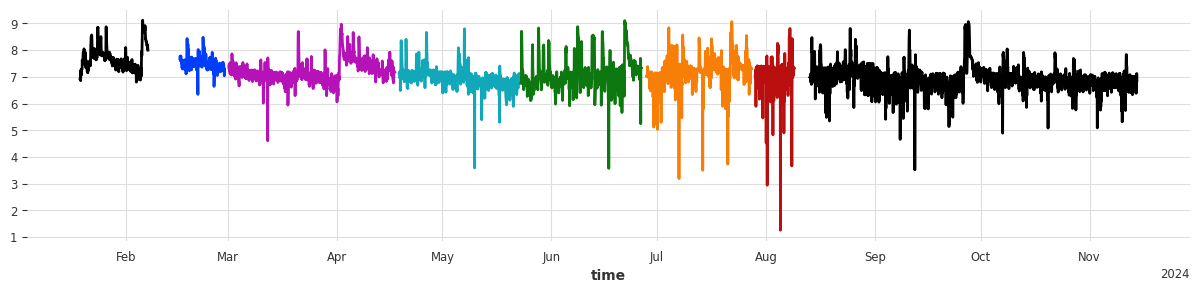

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for s in target_subseries:
    s.plot(ax=ax)
ax.legend().set_visible(False)

## Modelling

In [13]:
n_subseries = len(target_subseries)
n_features = expanded_covariates_subseries[0].shape[1]

slice_train = slice(0, n_subseries - 1)
slice_test = -1

train = target_subseries[slice_train]
test = target_subseries[slice_test]

train_future_covariates = expanded_covariates_subseries[slice_train]
test_future_covariates = expanded_covariates_subseries[slice_test]

output_chunk_length = 6
n_lags = 12

### Baseline

In [ ]:
from darts.models import NaiveMovingAverage

naive = NaiveMovingAverage(input_chunk_length=72)
naive.fit(train[2])  # Based on the previous plot, I select the longest period

NaiveMovingAverage(input_chunk_length=72)

### Candidates

In [16]:
regmodel = RegressionModel(
    model=Ridge(fit_intercept=False, solver="lsqr"),
    lags=n_lags,
    lags_future_covariates=(n_lags, 1),
    output_chunk_length=output_chunk_length,
)

xgbmodel = XGBModel(
    lags=n_lags,
    lags_future_covariates=(n_lags, 1),
    output_chunk_length=output_chunk_length,
)

In [17]:
class Model:
    def __init__(self, model: Union[RegressionModel, XGBModel]):
        self.model = model
        self.estimator = model.get_estimator(0, 0)


ridge = Model(regmodel)
xgb = Model(xgbmodel)

Model supports multi-output; a single estimator forecasts all the horizons and components.
Model supports multi-output; a single estimator forecasts all the horizons and components.


- In order to select features I run RFECV on every subseries. I will select the features that were selected in more than half of the subseries.

In [31]:
candidate = xgb

pbar = IntProgress(min=0, max=len(train))
display(pbar)

used_features = np.zeros(n_features)
for i, _ in enumerate(train):
    selector = RFECV(
        candidate.estimator,
        step=0.05,
        min_features_to_select=5,
        cv=TimeSeriesSplit(n_splits=4),
    )

    # The selection is made taking into account only the next time step
    selector = selector.fit(train_future_covariates[i].values(), train[i].values())
    used_features += selector.support_.astype(int)
    pbar.value += 1

# We only select features that have been selected in at least half of the subseries
index_relevant_features = [
    int(i) for i in np.where(used_features / n_subseries >= 0.5)[0]
]

selected_feature_names = list(
    expanded_covariates_subseries[0].columns[index_relevant_features]
)

selected_train_future_covariates = [
    s[selected_feature_names] for s in train_future_covariates
]
selected_test_future_covariates = test_future_covariates[selected_feature_names]

len(selected_feature_names)

IntProgress(value=0, max=7)

18

In [32]:
candidate.model.fit(
    train,
    future_covariates=selected_train_future_covariates,
)

XGBModel(lags=12, lags_past_covariates=None, lags_future_covariates=(12, 1), output_chunk_length=6, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

## Testing

In [ ]:
feature_i = SelectMultiple(options=selected_feature_names)


@interact(features=feature_i)
def plot_forecast(features):
    arbitrary_breakpoints = [18, 25, 30, 32, 58]  # test set has 70 points
    fig, axes = plt.subplots(
        2, len(arbitrary_breakpoints), figsize=(15, 5), sharey="row", sharex="col"
    )
    for i, n_split in enumerate(arbitrary_breakpoints):
        test_in, test_out = test.split_before(n_split)

        predicted_inflow = candidate.model.predict(
            series=test_in,
            n=output_chunk_length,
            future_covariates=selected_test_future_covariates,
        )

        actual_inflow = TimeSeries.from_series(
            test_in.append(test_out[predicted_inflow.time_index]).to_series()
        ).slice_n_points_before(end_ts=predicted_inflow.time_index[-1], n=14)

        predicted_inflow.plot(label="pred", ax=axes[0, i])
        actual_inflow.plot(label="actual", ax=axes[0, i])

        selected_test_future_covariates[list(features)].slice(
            start_ts=actual_inflow.time_index[0], end_ts=actual_inflow.time_index[-1]
        ).plot(label="pred", ax=axes[1, i])

        axes[0, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")
        axes[1, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")

    plt.tight_layout()


interactive(children=(SelectMultiple(description='features', options=('dow_1', 'dow_3', 'dow_5', 'feature_1', …

In [34]:
n_steps = len(test) - n_lags - output_chunk_length

pbar2 = IntProgress(min=0, max=n_steps)
display(pbar2)

errors = []
for t in range(n_steps):
    test_in, test_out = test.split_before(t + n_lags)
    pred = candidate.model.predict(
        output_chunk_length,
        series=test_in,
        future_covariates=selected_test_future_covariates,
    )

    actual_pred = np.expm1(pred.values())
    actual_values = np.expm1(test_out.slice_intersect(pred).values())

    error = actual_values - actual_pred
    errors.append(TimeSeries.from_values(values=error, columns=["error"]))

    pbar2.value += 1

IntProgress(value=0, max=2214)

<Axes: xlabel='time'>

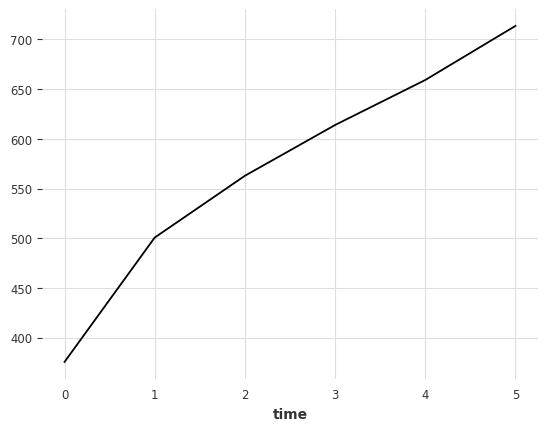

In [35]:
def rmse(x):
    return np.sqrt(np.mean(x**2))


pd.concat([e.to_dataframe() for e in errors]).reset_index().groupby("time").apply(
    rmse, include_groups=False
).plot()